In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
# split the data into train and test parts
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
data_df = pd.read_csv('simulation_sigmoidal.csv', index_col=0)
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
data_df

,sbj,trial,value_0,value_1,gaze_0,gaze_1,true_drift_0,true_drift_1,true_threshold,true_ndt,rt,choice
0,0,1,1.515307,5.702139,0.815368,0.184632,0.121320,1.248028,2.685671,0.795103,3.872103,1.0
1,0,2,5.800809,2.890693,0.057070,0.942930,0.368604,1.114728,2.685671,0.795103,4.199103,1.0
2,0,3,1.944349,5.512755,0.843520,0.156480,0.294848,0.969239,2.685671,0.795103,6.267103,0.0
3,0,4,3.209306,2.883418,0.287988,0.712012,0.287546,0.935792,2.685671,0.795103,2.464103,1.0
4,0,5,2.712884,5.816233,0.648374,0.351626,0.198987,1.571247,2.685671,0.795103,2.376103,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19969,99,196,5.225284,3.893592,0.069201,0.930799,0.280720,1.671857,2.387208,0.342712,2.245712,0.0
19970,99,197,1.903090,5.451513,0.860396,0.139604,0.267699,1.122338,2.387208,0.342712,1.828712,0.0
19971,99,198,5.879627,2.626809,0.333723,0.666277,1.663182,0.218219,2.387208,0.342712,1.650712,0.0
19972,99,199,1.102391,3.910916,0.890860,0.109140,0.172870,0.749631,2.387208,0.342712,1.477712,1.0


In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']], dtype=np.float32)
X_train = np.asarray(tr_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']], dtype=np.float32)

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']], dtype=np.float32)
X_test = np.asarray(ts_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']], dtype=np.float32)

print(X_train.shape, X_test.shape)

(13975, 4) (5999, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
#     return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)
    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-20)), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 312       
                                                                 
Total params: 605 (2.36 KB)
Trainable params: 605 (2.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 555ms/step - loss: 68127.9062
Epoch 2/3500
1/1 [==============================] - 0s 4ms/step - loss: 67815.8594
Epoch 3/3500
1/1 [==============================] - 0s 5ms/step - loss: 67591.3750
Epoch 4/3500
1/1 [==============================] - 0s 4ms/step - loss: 67404.2031
Epoch 5/3500
1/1 [==============================] - 0s 5ms/step - loss: 67238.6094
Epoch 6/3500
1/1 [==============================] - 0s 5ms/step - loss: 67087.3359
Epoch 7/3500
1/1 [==============================] - 0s 4ms/step - loss: 66946.2812
Epoch 8/3500
1/1 [==============================] - 0s 4ms/step - loss: 66812.9297
Epoch 9/3500
1/1 [==============================] - 0s 5ms/step - loss: 66685.5312
Epoch 10/3500
1/1 [==============================] - 0s 4ms/step - loss: 66562.8594
Epoch 11/3500
1/1 [==============================] - 0s 4ms/step - loss: 66444.0078
Epoch 12/3500
1/1 [==============================] - 0s 5ms/step - loss: 66328.3125

1/1 [==============================] - 0s 5ms/step - loss: 59656.3789
Epoch 99/3500
1/1 [==============================] - 0s 5ms/step - loss: 59601.2578
Epoch 100/3500
1/1 [==============================] - 0s 6ms/step - loss: 59546.4648
Epoch 101/3500
1/1 [==============================] - 0s 5ms/step - loss: 59492.0078
Epoch 102/3500
1/1 [==============================] - 0s 5ms/step - loss: 59437.8828
Epoch 103/3500
1/1 [==============================] - 0s 6ms/step - loss: 59384.0664
Epoch 104/3500
1/1 [==============================] - 0s 5ms/step - loss: 59330.5781
Epoch 105/3500
1/1 [==============================] - 0s 5ms/step - loss: 59277.4062
Epoch 106/3500
1/1 [==============================] - 0s 5ms/step - loss: 59224.5469
Epoch 107/3500
1/1 [==============================] - 0s 5ms/step - loss: 59172.0000
Epoch 108/3500
1/1 [==============================] - 0s 5ms/step - loss: 59119.7578
Epoch 109/3500
1/1 [==============================] - 0s 5ms/step - loss: 59067.8

1/1 [==============================] - 0s 5ms/step - loss: 55514.0039
Epoch 195/3500
1/1 [==============================] - 0s 5ms/step - loss: 55480.0078
Epoch 196/3500
1/1 [==============================] - 0s 5ms/step - loss: 55446.1484
Epoch 197/3500
1/1 [==============================] - 0s 5ms/step - loss: 55412.4219
Epoch 198/3500
1/1 [==============================] - 0s 5ms/step - loss: 55378.8359
Epoch 199/3500
1/1 [==============================] - 0s 5ms/step - loss: 55345.3828
Epoch 200/3500
1/1 [==============================] - 0s 6ms/step - loss: 55312.0625
Epoch 201/3500
1/1 [==============================] - 0s 5ms/step - loss: 55278.8672
Epoch 202/3500
1/1 [==============================] - 0s 6ms/step - loss: 55245.8086
Epoch 203/3500
1/1 [==============================] - 0s 5ms/step - loss: 55212.8789
Epoch 204/3500
1/1 [==============================] - 0s 5ms/step - loss: 55180.0781
Epoch 205/3500
1/1 [==============================] - 0s 5ms/step - loss: 55147.

1/1 [==============================] - 0s 5ms/step - loss: 52322.0898
Epoch 291/3500
1/1 [==============================] - 0s 6ms/step - loss: 52286.8477
Epoch 292/3500
1/1 [==============================] - 0s 5ms/step - loss: 52251.5078
Epoch 293/3500
1/1 [==============================] - 0s 5ms/step - loss: 52216.0664
Epoch 294/3500
1/1 [==============================] - 0s 5ms/step - loss: 52180.5352
Epoch 295/3500
1/1 [==============================] - 0s 5ms/step - loss: 52144.9102
Epoch 296/3500
1/1 [==============================] - 0s 6ms/step - loss: 52109.1953
Epoch 297/3500
1/1 [==============================] - 0s 5ms/step - loss: 52073.3828
Epoch 298/3500
1/1 [==============================] - 0s 5ms/step - loss: 52037.4922
Epoch 299/3500
1/1 [==============================] - 0s 5ms/step - loss: 52001.5234
Epoch 300/3500
1/1 [==============================] - 0s 6ms/step - loss: 51965.4688
Epoch 301/3500
1/1 [==============================] - 0s 5ms/step - loss: 51929.

1/1 [==============================] - 0s 5ms/step - loss: 48103.9766
Epoch 387/3500
1/1 [==============================] - 0s 5ms/step - loss: 48056.9102
Epoch 388/3500
1/1 [==============================] - 0s 6ms/step - loss: 48010.1328
Epoch 389/3500
1/1 [==============================] - 0s 5ms/step - loss: 47963.6406
Epoch 390/3500
1/1 [==============================] - 0s 5ms/step - loss: 47917.4219
Epoch 391/3500
1/1 [==============================] - 0s 5ms/step - loss: 47871.4648
Epoch 392/3500
1/1 [==============================] - 0s 5ms/step - loss: 47825.7656
Epoch 393/3500
1/1 [==============================] - 0s 5ms/step - loss: 47780.2969
Epoch 394/3500
1/1 [==============================] - 0s 5ms/step - loss: 47735.0625
Epoch 395/3500
1/1 [==============================] - 0s 5ms/step - loss: 47690.0625
Epoch 396/3500
1/1 [==============================] - 0s 5ms/step - loss: 47645.2734
Epoch 397/3500
1/1 [==============================] - 0s 5ms/step - loss: 47600.

1/1 [==============================] - 0s 8ms/step - loss: 44248.8906
Epoch 483/3500
1/1 [==============================] - 0s 6ms/step - loss: 44213.3750
Epoch 484/3500
1/1 [==============================] - 0s 6ms/step - loss: 44177.9766
Epoch 485/3500
1/1 [==============================] - 0s 5ms/step - loss: 44142.6484
Epoch 486/3500
1/1 [==============================] - 0s 5ms/step - loss: 44107.4414
Epoch 487/3500
1/1 [==============================] - 0s 6ms/step - loss: 44072.2969
Epoch 488/3500
1/1 [==============================] - 0s 5ms/step - loss: 44037.2812
Epoch 489/3500
1/1 [==============================] - 0s 5ms/step - loss: 44002.3281
Epoch 490/3500
1/1 [==============================] - 0s 6ms/step - loss: 43967.5000
Epoch 491/3500
1/1 [==============================] - 0s 5ms/step - loss: 43932.7344
Epoch 492/3500
1/1 [==============================] - 0s 5ms/step - loss: 43898.0938
Epoch 493/3500
1/1 [==============================] - 0s 5ms/step - loss: 43863.

1/1 [==============================] - 0s 5ms/step - loss: 41212.0156
Epoch 579/3500
1/1 [==============================] - 0s 5ms/step - loss: 41183.3672
Epoch 580/3500
1/1 [==============================] - 0s 6ms/step - loss: 41154.8203
Epoch 581/3500
1/1 [==============================] - 0s 5ms/step - loss: 41126.2734
Epoch 582/3500
1/1 [==============================] - 0s 5ms/step - loss: 41097.8281
Epoch 583/3500
1/1 [==============================] - 0s 5ms/step - loss: 41069.3789
Epoch 584/3500
1/1 [==============================] - 0s 5ms/step - loss: 41041.0391
Epoch 585/3500
1/1 [==============================] - 0s 5ms/step - loss: 41012.7031
Epoch 586/3500
1/1 [==============================] - 0s 7ms/step - loss: 40984.4688
Epoch 587/3500
1/1 [==============================] - 0s 6ms/step - loss: 40956.2266
Epoch 588/3500
1/1 [==============================] - 0s 5ms/step - loss: 40928.0469
Epoch 589/3500
1/1 [==============================] - 0s 5ms/step - loss: 40899.

1/1 [==============================] - 0s 6ms/step - loss: 38690.8594
Epoch 675/3500
1/1 [==============================] - 0s 5ms/step - loss: 38666.8750
Epoch 676/3500
1/1 [==============================] - 0s 5ms/step - loss: 38642.9531
Epoch 677/3500
1/1 [==============================] - 0s 5ms/step - loss: 38619.0547
Epoch 678/3500
1/1 [==============================] - 0s 6ms/step - loss: 38595.2305
Epoch 679/3500
1/1 [==============================] - 0s 5ms/step - loss: 38571.4180
Epoch 680/3500
1/1 [==============================] - 0s 5ms/step - loss: 38547.6758
Epoch 681/3500
1/1 [==============================] - 0s 5ms/step - loss: 38523.9453
Epoch 682/3500
1/1 [==============================] - 0s 6ms/step - loss: 38500.2656
Epoch 683/3500
1/1 [==============================] - 0s 5ms/step - loss: 38476.6133
Epoch 684/3500
1/1 [==============================] - 0s 6ms/step - loss: 38453.0078
Epoch 685/3500
1/1 [==============================] - 0s 5ms/step - loss: 38429.

1/1 [==============================] - 0s 5ms/step - loss: 36569.4531
Epoch 771/3500
1/1 [==============================] - 0s 5ms/step - loss: 36549.1367
Epoch 772/3500
1/1 [==============================] - 0s 5ms/step - loss: 36528.8750
Epoch 773/3500
1/1 [==============================] - 0s 5ms/step - loss: 36508.6250
Epoch 774/3500
1/1 [==============================] - 0s 5ms/step - loss: 36488.4375
Epoch 775/3500
1/1 [==============================] - 0s 5ms/step - loss: 36468.2500
Epoch 776/3500
1/1 [==============================] - 0s 5ms/step - loss: 36448.1328
Epoch 777/3500
1/1 [==============================] - 0s 5ms/step - loss: 36428.0234
Epoch 778/3500
1/1 [==============================] - 0s 5ms/step - loss: 36407.9766
Epoch 779/3500
1/1 [==============================] - 0s 5ms/step - loss: 36387.9258
Epoch 780/3500
1/1 [==============================] - 0s 5ms/step - loss: 36367.9453
Epoch 781/3500
1/1 [==============================] - 0s 5ms/step - loss: 36347.

1/1 [==============================] - 0s 5ms/step - loss: 34774.2500
Epoch 867/3500
1/1 [==============================] - 0s 6ms/step - loss: 34757.1211
Epoch 868/3500
1/1 [==============================] - 0s 5ms/step - loss: 34740.0625
Epoch 869/3500
1/1 [==============================] - 0s 5ms/step - loss: 34723.0000
Epoch 870/3500
1/1 [==============================] - 0s 5ms/step - loss: 34706.0078
Epoch 871/3500
1/1 [==============================] - 0s 5ms/step - loss: 34689.0078
Epoch 872/3500
1/1 [==============================] - 0s 5ms/step - loss: 34672.0781
Epoch 873/3500
1/1 [==============================] - 0s 6ms/step - loss: 34655.1406
Epoch 874/3500
1/1 [==============================] - 0s 5ms/step - loss: 34638.2734
Epoch 875/3500
1/1 [==============================] - 0s 5ms/step - loss: 34621.3945
Epoch 876/3500
1/1 [==============================] - 0s 6ms/step - loss: 34604.6016
Epoch 877/3500
1/1 [==============================] - 0s 5ms/step - loss: 34587.

1/1 [==============================] - 0s 6ms/step - loss: 33270.4883
Epoch 963/3500
1/1 [==============================] - 0s 5ms/step - loss: 33256.0547
Epoch 964/3500
1/1 [==============================] - 0s 5ms/step - loss: 33242.5000
Epoch 965/3500
1/1 [==============================] - 0s 6ms/step - loss: 33229.2344
Epoch 966/3500
1/1 [==============================] - 0s 5ms/step - loss: 33217.6875
Epoch 967/3500
1/1 [==============================] - 0s 5ms/step - loss: 33207.6328
Epoch 968/3500
1/1 [==============================] - 0s 6ms/step - loss: 33194.8203
Epoch 969/3500
1/1 [==============================] - 0s 5ms/step - loss: 33177.1133
Epoch 970/3500
1/1 [==============================] - 0s 5ms/step - loss: 33159.8594
Epoch 971/3500
1/1 [==============================] - 0s 5ms/step - loss: 33144.2109
Epoch 972/3500
1/1 [==============================] - 0s 5ms/step - loss: 33129.8516
Epoch 973/3500
1/1 [==============================] - 0s 5ms/step - loss: 33116.

1/1 [==============================] - 0s 7ms/step - loss: 32047.9258
Epoch 1058/3500
1/1 [==============================] - 0s 6ms/step - loss: 32037.4219
Epoch 1059/3500
1/1 [==============================] - 0s 8ms/step - loss: 32025.3047
Epoch 1060/3500
1/1 [==============================] - 0s 7ms/step - loss: 32015.6660
Epoch 1061/3500
1/1 [==============================] - 0s 7ms/step - loss: 32010.1445
Epoch 1062/3500
1/1 [==============================] - 0s 6ms/step - loss: 32002.9453
Epoch 1063/3500
1/1 [==============================] - 0s 6ms/step - loss: 31983.7461
Epoch 1064/3500
1/1 [==============================] - 0s 6ms/step - loss: 31965.7168
Epoch 1065/3500
1/1 [==============================] - 0s 6ms/step - loss: 31951.1250
Epoch 1066/3500
1/1 [==============================] - 0s 7ms/step - loss: 31938.4961
Epoch 1067/3500
1/1 [==============================] - 0s 6ms/step - loss: 31926.8262
Epoch 1068/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 31051.4160
Epoch 1153/3500
1/1 [==============================] - 0s 8ms/step - loss: 31046.6641
Epoch 1154/3500
1/1 [==============================] - 0s 12ms/step - loss: 31042.1133
Epoch 1155/3500
1/1 [==============================] - 0s 7ms/step - loss: 31033.3301
Epoch 1156/3500
1/1 [==============================] - 0s 6ms/step - loss: 31022.1992
Epoch 1157/3500
1/1 [==============================] - 0s 6ms/step - loss: 31007.9375
Epoch 1158/3500
1/1 [==============================] - 0s 6ms/step - loss: 30996.0195
Epoch 1159/3500
1/1 [==============================] - 0s 6ms/step - loss: 30984.1973
Epoch 1160/3500
1/1 [==============================] - 0s 6ms/step - loss: 30974.6973
Epoch 1161/3500
1/1 [==============================] - 0s 6ms/step - loss: 30965.4746
Epoch 1162/3500
1/1 [==============================] - 0s 6ms/step - loss: 30958.5352
Epoch 1163/3500
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 30264.3359
Epoch 1248/3500
1/1 [==============================] - 0s 6ms/step - loss: 30262.4727
Epoch 1249/3500
1/1 [==============================] - 0s 6ms/step - loss: 30258.1484
Epoch 1250/3500
1/1 [==============================] - 0s 5ms/step - loss: 30252.2695
Epoch 1251/3500
1/1 [==============================] - 0s 6ms/step - loss: 30239.8789
Epoch 1252/3500
1/1 [==============================] - 0s 6ms/step - loss: 30230.3125
Epoch 1253/3500
1/1 [==============================] - 0s 5ms/step - loss: 30219.1562
Epoch 1254/3500
1/1 [==============================] - 0s 7ms/step - loss: 30212.5840
Epoch 1255/3500
1/1 [==============================] - 0s 6ms/step - loss: 30204.5605
Epoch 1256/3500
1/1 [==============================] - 0s 7ms/step - loss: 30197.2695
Epoch 1257/3500
1/1 [==============================] - 0s 6ms/step - loss: 30188.3457
Epoch 1258/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 29672.4141
Epoch 1343/3500
1/1 [==============================] - 0s 5ms/step - loss: 29663.2188
Epoch 1344/3500
1/1 [==============================] - 0s 5ms/step - loss: 29653.8809
Epoch 1345/3500
1/1 [==============================] - 0s 6ms/step - loss: 29643.9863
Epoch 1346/3500
1/1 [==============================] - 0s 6ms/step - loss: 29636.8125
Epoch 1347/3500
1/1 [==============================] - 0s 5ms/step - loss: 29630.0684
Epoch 1348/3500
1/1 [==============================] - 0s 5ms/step - loss: 29627.1621
Epoch 1349/3500
1/1 [==============================] - 0s 5ms/step - loss: 29624.3242
Epoch 1350/3500
1/1 [==============================] - 0s 6ms/step - loss: 29620.4570
Epoch 1351/3500
1/1 [==============================] - 0s 6ms/step - loss: 29611.9766
Epoch 1352/3500
1/1 [==============================] - 0s 5ms/step - loss: 29603.5566
Epoch 1353/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 29214.5605
Epoch 1438/3500
1/1 [==============================] - 0s 6ms/step - loss: 29208.4336
Epoch 1439/3500
1/1 [==============================] - 0s 7ms/step - loss: 29201.2695
Epoch 1440/3500
1/1 [==============================] - 0s 6ms/step - loss: 29196.1309
Epoch 1441/3500
1/1 [==============================] - 0s 6ms/step - loss: 29189.7227
Epoch 1442/3500
1/1 [==============================] - 0s 6ms/step - loss: 29184.4629
Epoch 1443/3500
1/1 [==============================] - 0s 6ms/step - loss: 29179.2754
Epoch 1444/3500
1/1 [==============================] - 0s 6ms/step - loss: 29176.4629
Epoch 1445/3500
1/1 [==============================] - 0s 6ms/step - loss: 29172.8301
Epoch 1446/3500
1/1 [==============================] - 0s 7ms/step - loss: 29170.0625
Epoch 1447/3500
1/1 [==============================] - 0s 7ms/step - loss: 29169.4434
Epoch 1448/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 28876.3965
Epoch 1533/3500
1/1 [==============================] - 0s 6ms/step - loss: 28872.4531
Epoch 1534/3500
1/1 [==============================] - 0s 7ms/step - loss: 28868.9844
Epoch 1535/3500
1/1 [==============================] - 0s 7ms/step - loss: 28867.0840
Epoch 1536/3500
1/1 [==============================] - 0s 7ms/step - loss: 28866.3906
Epoch 1537/3500
1/1 [==============================] - 0s 6ms/step - loss: 28865.8945
Epoch 1538/3500
1/1 [==============================] - 0s 6ms/step - loss: 28871.9160
Epoch 1539/3500
1/1 [==============================] - 0s 6ms/step - loss: 28879.4121
Epoch 1540/3500
1/1 [==============================] - 0s 6ms/step - loss: 28882.9902
Epoch 1541/3500
1/1 [==============================] - 0s 7ms/step - loss: 28875.9199
Epoch 1542/3500
1/1 [==============================] - 0s 6ms/step - loss: 28868.0117
Epoch 1543/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 28634.6113
Epoch 1628/3500
1/1 [==============================] - 0s 6ms/step - loss: 28633.4062
Epoch 1629/3500
1/1 [==============================] - 0s 6ms/step - loss: 28632.5312
Epoch 1630/3500
1/1 [==============================] - 0s 6ms/step - loss: 28635.2031
Epoch 1631/3500
1/1 [==============================] - 0s 7ms/step - loss: 28639.3867
Epoch 1632/3500
1/1 [==============================] - 0s 5ms/step - loss: 28650.5469
Epoch 1633/3500
1/1 [==============================] - 0s 7ms/step - loss: 28666.6914
Epoch 1634/3500
1/1 [==============================] - 0s 6ms/step - loss: 28650.2969
Epoch 1635/3500
1/1 [==============================] - 0s 7ms/step - loss: 28633.4473
Epoch 1636/3500
1/1 [==============================] - 0s 6ms/step - loss: 28621.9219
Epoch 1637/3500
1/1 [==============================] - 0s 6ms/step - loss: 28616.3340
Epoch 1638/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 28456.0273
Epoch 1723/3500
1/1 [==============================] - 0s 6ms/step - loss: 28462.6641
Epoch 1724/3500
1/1 [==============================] - 0s 7ms/step - loss: 28471.7246
Epoch 1725/3500
1/1 [==============================] - 0s 6ms/step - loss: 28477.2559
Epoch 1726/3500
1/1 [==============================] - 0s 7ms/step - loss: 28468.0879
Epoch 1727/3500
1/1 [==============================] - 0s 6ms/step - loss: 28458.9902
Epoch 1728/3500
1/1 [==============================] - 0s 6ms/step - loss: 28448.6875
Epoch 1729/3500
1/1 [==============================] - 0s 6ms/step - loss: 28441.4922
Epoch 1730/3500
1/1 [==============================] - 0s 6ms/step - loss: 28435.5762
Epoch 1731/3500
1/1 [==============================] - 0s 7ms/step - loss: 28431.1250
Epoch 1732/3500
1/1 [==============================] - 0s 5ms/step - loss: 28429.8398
Epoch 1733/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 28313.4082
Epoch 1818/3500
1/1 [==============================] - 0s 6ms/step - loss: 28301.4863
Epoch 1819/3500
1/1 [==============================] - 0s 7ms/step - loss: 28295.7227
Epoch 1820/3500
1/1 [==============================] - 0s 7ms/step - loss: 28291.4082
Epoch 1821/3500
1/1 [==============================] - 0s 6ms/step - loss: 28289.2930
Epoch 1822/3500
1/1 [==============================] - 0s 6ms/step - loss: 28286.2500
Epoch 1823/3500
1/1 [==============================] - 0s 6ms/step - loss: 28287.1328
Epoch 1824/3500
1/1 [==============================] - 0s 6ms/step - loss: 28287.9609
Epoch 1825/3500
1/1 [==============================] - 0s 5ms/step - loss: 28291.8809
Epoch 1826/3500
1/1 [==============================] - 0s 6ms/step - loss: 28297.4766
Epoch 1827/3500
1/1 [==============================] - 0s 6ms/step - loss: 28306.9531
Epoch 1828/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 28171.9238
Epoch 1913/3500
1/1 [==============================] - 0s 6ms/step - loss: 28170.6914
Epoch 1914/3500
1/1 [==============================] - 0s 6ms/step - loss: 28169.1172
Epoch 1915/3500
1/1 [==============================] - 0s 6ms/step - loss: 28168.9707
Epoch 1916/3500
1/1 [==============================] - 0s 6ms/step - loss: 28169.3477
Epoch 1917/3500
1/1 [==============================] - 0s 5ms/step - loss: 28171.3008
Epoch 1918/3500
1/1 [==============================] - 0s 6ms/step - loss: 28175.5586
Epoch 1919/3500
1/1 [==============================] - 0s 5ms/step - loss: 28183.2617
Epoch 1920/3500
1/1 [==============================] - 0s 6ms/step - loss: 28192.0156
Epoch 1921/3500
1/1 [==============================] - 0s 7ms/step - loss: 28198.2695
Epoch 1922/3500
1/1 [==============================] - 0s 5ms/step - loss: 28195.3242
Epoch 1923/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 28077.3184
Epoch 2008/3500
1/1 [==============================] - 0s 6ms/step - loss: 28095.7500
Epoch 2009/3500
1/1 [==============================] - 0s 5ms/step - loss: 28146.3203
Epoch 2010/3500
1/1 [==============================] - 0s 5ms/step - loss: 28164.9375
Epoch 2011/3500
1/1 [==============================] - 0s 6ms/step - loss: 28110.0039
Epoch 2012/3500
1/1 [==============================] - 0s 5ms/step - loss: 28079.0000
Epoch 2013/3500
1/1 [==============================] - 0s 6ms/step - loss: 28067.9863
Epoch 2014/3500
1/1 [==============================] - 0s 6ms/step - loss: 28062.8027
Epoch 2015/3500
1/1 [==============================] - 0s 5ms/step - loss: 28060.2754
Epoch 2016/3500
1/1 [==============================] - 0s 6ms/step - loss: 28058.8711
Epoch 2017/3500
1/1 [==============================] - 0s 5ms/step - loss: 28059.0547
Epoch 2018/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 28007.5176
Epoch 2103/3500
1/1 [==============================] - 0s 6ms/step - loss: 28019.5352
Epoch 2104/3500
1/1 [==============================] - 0s 7ms/step - loss: 28032.6133
Epoch 2105/3500
1/1 [==============================] - 0s 6ms/step - loss: 28022.3281
Epoch 2106/3500
1/1 [==============================] - 0s 7ms/step - loss: 28009.8691
Epoch 2107/3500
1/1 [==============================] - 0s 7ms/step - loss: 28000.3145
Epoch 2108/3500
1/1 [==============================] - 0s 6ms/step - loss: 27994.5000
Epoch 2109/3500
1/1 [==============================] - 0s 7ms/step - loss: 27991.6445
Epoch 2110/3500
1/1 [==============================] - 0s 6ms/step - loss: 27988.9043
Epoch 2111/3500
1/1 [==============================] - 0s 7ms/step - loss: 27985.5742
Epoch 2112/3500
1/1 [==============================] - 0s 7ms/step - loss: 27982.9785
Epoch 2113/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27921.1973
Epoch 2198/3500
1/1 [==============================] - 0s 6ms/step - loss: 27920.0996
Epoch 2199/3500
1/1 [==============================] - 0s 7ms/step - loss: 27919.5020
Epoch 2200/3500
1/1 [==============================] - 0s 5ms/step - loss: 27922.3828
Epoch 2201/3500
1/1 [==============================] - 0s 7ms/step - loss: 27923.7109
Epoch 2202/3500
1/1 [==============================] - 0s 7ms/step - loss: 27929.2383
Epoch 2203/3500
1/1 [==============================] - 0s 7ms/step - loss: 27937.5059
Epoch 2204/3500
1/1 [==============================] - 0s 6ms/step - loss: 27947.0684
Epoch 2205/3500
1/1 [==============================] - 0s 5ms/step - loss: 27956.9922
Epoch 2206/3500
1/1 [==============================] - 0s 6ms/step - loss: 28007.4707
Epoch 2207/3500
1/1 [==============================] - 0s 6ms/step - loss: 27938.1172
Epoch 2208/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 27863.7695
Epoch 2293/3500
1/1 [==============================] - 0s 6ms/step - loss: 27863.0312
Epoch 2294/3500
1/1 [==============================] - 0s 6ms/step - loss: 27865.2598
Epoch 2295/3500
1/1 [==============================] - 0s 7ms/step - loss: 27869.6484
Epoch 2296/3500
1/1 [==============================] - 0s 6ms/step - loss: 27877.9824
Epoch 2297/3500
1/1 [==============================] - 0s 6ms/step - loss: 27884.3223
Epoch 2298/3500
1/1 [==============================] - 0s 7ms/step - loss: 27883.8379
Epoch 2299/3500
1/1 [==============================] - 0s 6ms/step - loss: 27882.9336
Epoch 2300/3500
1/1 [==============================] - 0s 6ms/step - loss: 27883.2988
Epoch 2301/3500
1/1 [==============================] - 0s 6ms/step - loss: 27885.6309
Epoch 2302/3500
1/1 [==============================] - 0s 6ms/step - loss: 27892.2344
Epoch 2303/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 27840.2344
Epoch 2388/3500
1/1 [==============================] - 0s 8ms/step - loss: 27834.6172
Epoch 2389/3500
1/1 [==============================] - 0s 7ms/step - loss: 27828.3203
Epoch 2390/3500
1/1 [==============================] - 0s 8ms/step - loss: 27824.6953
Epoch 2391/3500
1/1 [==============================] - 0s 7ms/step - loss: 27823.4648
Epoch 2392/3500
1/1 [==============================] - 0s 7ms/step - loss: 27823.0645
Epoch 2393/3500
1/1 [==============================] - 0s 8ms/step - loss: 27822.5176
Epoch 2394/3500
1/1 [==============================] - 0s 7ms/step - loss: 27823.2383
Epoch 2395/3500
1/1 [==============================] - 0s 8ms/step - loss: 27826.0977
Epoch 2396/3500
1/1 [==============================] - 0s 8ms/step - loss: 27833.6797
Epoch 2397/3500
1/1 [==============================] - 0s 8ms/step - loss: 27845.3906
Epoch 2398/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 27816.1289
Epoch 2483/3500
1/1 [==============================] - 0s 6ms/step - loss: 27897.1172
Epoch 2484/3500
1/1 [==============================] - 0s 6ms/step - loss: 27801.4062
Epoch 2485/3500
1/1 [==============================] - 0s 6ms/step - loss: 27785.5938
Epoch 2486/3500
1/1 [==============================] - 0s 6ms/step - loss: 27782.0820
Epoch 2487/3500
1/1 [==============================] - 0s 6ms/step - loss: 27782.0820
Epoch 2488/3500
1/1 [==============================] - 0s 6ms/step - loss: 27785.7051
Epoch 2489/3500
1/1 [==============================] - 0s 6ms/step - loss: 27789.2266
Epoch 2490/3500
1/1 [==============================] - 0s 6ms/step - loss: 27787.4688
Epoch 2491/3500
1/1 [==============================] - 0s 6ms/step - loss: 27787.6211
Epoch 2492/3500
1/1 [==============================] - 0s 6ms/step - loss: 27787.1484
Epoch 2493/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 27761.2344
Epoch 2578/3500
1/1 [==============================] - 0s 6ms/step - loss: 27757.5195
Epoch 2579/3500
1/1 [==============================] - 0s 6ms/step - loss: 27754.5684
Epoch 2580/3500
1/1 [==============================] - 0s 7ms/step - loss: 27758.4668
Epoch 2581/3500
1/1 [==============================] - 0s 6ms/step - loss: 27752.4141
Epoch 2582/3500
1/1 [==============================] - 0s 7ms/step - loss: 27757.4922
Epoch 2583/3500
1/1 [==============================] - 0s 6ms/step - loss: 27757.1855
Epoch 2584/3500
1/1 [==============================] - 0s 7ms/step - loss: 27762.1367
Epoch 2585/3500
1/1 [==============================] - 0s 7ms/step - loss: 27771.7148
Epoch 2586/3500
1/1 [==============================] - 0s 6ms/step - loss: 27780.0430
Epoch 2587/3500
1/1 [==============================] - 0s 7ms/step - loss: 27782.1543
Epoch 2588/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 27749.6504
Epoch 2673/3500
1/1 [==============================] - 0s 7ms/step - loss: 27744.1074
Epoch 2674/3500
1/1 [==============================] - 0s 8ms/step - loss: 27746.0020
Epoch 2675/3500
1/1 [==============================] - 0s 8ms/step - loss: 27744.8672
Epoch 2676/3500
1/1 [==============================] - 0s 6ms/step - loss: 27749.8359
Epoch 2677/3500
1/1 [==============================] - 0s 7ms/step - loss: 27735.1367
Epoch 2678/3500
1/1 [==============================] - 0s 8ms/step - loss: 27733.0332
Epoch 2679/3500
1/1 [==============================] - 0s 9ms/step - loss: 27728.6797
Epoch 2680/3500
1/1 [==============================] - 0s 8ms/step - loss: 27730.5938
Epoch 2681/3500
1/1 [==============================] - 0s 8ms/step - loss: 27728.8320
Epoch 2682/3500
1/1 [==============================] - 0s 6ms/step - loss: 27812.8164
Epoch 2683/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 27710.6406
Epoch 2768/3500
1/1 [==============================] - 0s 7ms/step - loss: 27712.6328
Epoch 2769/3500
1/1 [==============================] - 0s 6ms/step - loss: 27719.0918
Epoch 2770/3500
1/1 [==============================] - 0s 7ms/step - loss: 27728.3809
Epoch 2771/3500
1/1 [==============================] - 0s 6ms/step - loss: 27739.0508
Epoch 2772/3500
1/1 [==============================] - 0s 7ms/step - loss: 27745.0664
Epoch 2773/3500
1/1 [==============================] - 0s 8ms/step - loss: 27736.6973
Epoch 2774/3500
1/1 [==============================] - 0s 7ms/step - loss: 27728.6016
Epoch 2775/3500
1/1 [==============================] - 0s 8ms/step - loss: 27724.6602
Epoch 2776/3500
1/1 [==============================] - 0s 7ms/step - loss: 27725.8945
Epoch 2777/3500
1/1 [==============================] - 0s 9ms/step - loss: 27725.2891
Epoch 2778/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 11ms/step - loss: 27718.8008
Epoch 2863/3500
1/1 [==============================] - 0s 6ms/step - loss: 27710.7637
Epoch 2864/3500
1/1 [==============================] - 0s 7ms/step - loss: 27705.7910
Epoch 2865/3500
1/1 [==============================] - 0s 6ms/step - loss: 27702.8359
Epoch 2866/3500
1/1 [==============================] - 0s 6ms/step - loss: 27699.0098
Epoch 2867/3500
1/1 [==============================] - 0s 6ms/step - loss: 27705.5312
Epoch 2868/3500
1/1 [==============================] - 0s 5ms/step - loss: 27705.9746
Epoch 2869/3500
1/1 [==============================] - 0s 7ms/step - loss: 27704.3711
Epoch 2870/3500
1/1 [==============================] - 0s 6ms/step - loss: 27702.8926
Epoch 2871/3500
1/1 [==============================] - 0s 8ms/step - loss: 27704.5312
Epoch 2872/3500
1/1 [==============================] - 0s 7ms/step - loss: 27703.5391
Epoch 2873/3500
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 27689.1445
Epoch 2958/3500
1/1 [==============================] - 0s 7ms/step - loss: 27686.8066
Epoch 2959/3500
1/1 [==============================] - 0s 8ms/step - loss: 27685.4805
Epoch 2960/3500
1/1 [==============================] - 0s 7ms/step - loss: 27694.9551
Epoch 2961/3500
1/1 [==============================] - 0s 7ms/step - loss: 27711.3633
Epoch 2962/3500
1/1 [==============================] - 0s 6ms/step - loss: 27716.8008
Epoch 2963/3500
1/1 [==============================] - 0s 6ms/step - loss: 27718.8438
Epoch 2964/3500
1/1 [==============================] - 0s 7ms/step - loss: 27713.8281
Epoch 2965/3500
1/1 [==============================] - 0s 6ms/step - loss: 27704.5859
Epoch 2966/3500
1/1 [==============================] - 0s 8ms/step - loss: 27700.3262
Epoch 2967/3500
1/1 [==============================] - 0s 7ms/step - loss: 27692.1660
Epoch 2968/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 27675.9629
Epoch 3053/3500
1/1 [==============================] - 0s 6ms/step - loss: 27678.1680
Epoch 3054/3500
1/1 [==============================] - 0s 7ms/step - loss: 27685.3047
Epoch 3055/3500
1/1 [==============================] - 0s 6ms/step - loss: 27703.6523
Epoch 3056/3500
1/1 [==============================] - 0s 7ms/step - loss: 27729.5527
Epoch 3057/3500
1/1 [==============================] - 0s 6ms/step - loss: 27739.5000
Epoch 3058/3500
1/1 [==============================] - 0s 6ms/step - loss: 27712.5586
Epoch 3059/3500
1/1 [==============================] - 0s 7ms/step - loss: 27693.6465
Epoch 3060/3500
1/1 [==============================] - 0s 7ms/step - loss: 27681.8516
Epoch 3061/3500
1/1 [==============================] - 0s 7ms/step - loss: 27680.7656
Epoch 3062/3500
1/1 [==============================] - 0s 7ms/step - loss: 27675.0820
Epoch 3063/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 27672.0566
Epoch 3148/3500
1/1 [==============================] - 0s 7ms/step - loss: 27668.1660
Epoch 3149/3500
1/1 [==============================] - 0s 6ms/step - loss: 27664.9883
Epoch 3150/3500
1/1 [==============================] - 0s 7ms/step - loss: 27665.6641
Epoch 3151/3500
1/1 [==============================] - 0s 7ms/step - loss: 27666.4766
Epoch 3152/3500
1/1 [==============================] - 0s 7ms/step - loss: 27664.8984
Epoch 3153/3500
1/1 [==============================] - 0s 7ms/step - loss: 27664.9805
Epoch 3154/3500
1/1 [==============================] - 0s 7ms/step - loss: 27666.1895
Epoch 3155/3500
1/1 [==============================] - 0s 6ms/step - loss: 27670.8477
Epoch 3156/3500
1/1 [==============================] - 0s 6ms/step - loss: 27674.5977
Epoch 3157/3500
1/1 [==============================] - 0s 8ms/step - loss: 27684.1660
Epoch 3158/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 27677.7988
Epoch 3243/3500
1/1 [==============================] - 0s 6ms/step - loss: 27682.2461
Epoch 3244/3500
1/1 [==============================] - 0s 5ms/step - loss: 27679.8672
Epoch 3245/3500
1/1 [==============================] - 0s 6ms/step - loss: 27678.2207
Epoch 3246/3500
1/1 [==============================] - 0s 5ms/step - loss: 27657.1875
Epoch 3247/3500
1/1 [==============================] - 0s 6ms/step - loss: 27657.8613
Epoch 3248/3500
1/1 [==============================] - 0s 6ms/step - loss: 27662.0098
Epoch 3249/3500
1/1 [==============================] - 0s 6ms/step - loss: 27670.6875
Epoch 3250/3500
1/1 [==============================] - 0s 5ms/step - loss: 27691.6445
Epoch 3251/3500
1/1 [==============================] - 0s 6ms/step - loss: 27719.8770
Epoch 3252/3500
1/1 [==============================] - 0s 6ms/step - loss: 27701.6250
Epoch 3253/3500
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 27664.0684
Epoch 3338/3500
1/1 [==============================] - 0s 5ms/step - loss: 27657.6055
Epoch 3339/3500
1/1 [==============================] - 0s 6ms/step - loss: 27654.7266
Epoch 3340/3500
1/1 [==============================] - 0s 6ms/step - loss: 27658.5508
Epoch 3341/3500
1/1 [==============================] - 0s 6ms/step - loss: 27659.8984
Epoch 3342/3500
1/1 [==============================] - 0s 6ms/step - loss: 27668.9668
Epoch 3343/3500
1/1 [==============================] - 0s 5ms/step - loss: 27669.3359
Epoch 3344/3500
1/1 [==============================] - 0s 5ms/step - loss: 27670.8477
Epoch 3345/3500
1/1 [==============================] - 0s 6ms/step - loss: 27667.2129
Epoch 3346/3500
1/1 [==============================] - 0s 6ms/step - loss: 27662.6172
Epoch 3347/3500
1/1 [==============================] - 0s 6ms/step - loss: 27667.9824
Epoch 3348/3500
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 27653.1777
Epoch 3433/3500
1/1 [==============================] - 0s 6ms/step - loss: 27658.5684
Epoch 3434/3500
1/1 [==============================] - 0s 6ms/step - loss: 27677.2207
Epoch 3435/3500
1/1 [==============================] - 0s 6ms/step - loss: 27688.5469
Epoch 3436/3500
1/1 [==============================] - 0s 6ms/step - loss: 27755.5488
Epoch 3437/3500
1/1 [==============================] - 0s 6ms/step - loss: 27660.3438
Epoch 3438/3500
1/1 [==============================] - 0s 5ms/step - loss: 27656.8086
Epoch 3439/3500
1/1 [==============================] - 0s 5ms/step - loss: 27649.8906
Epoch 3440/3500
1/1 [==============================] - 0s 6ms/step - loss: 27651.6289
Epoch 3441/3500
1/1 [==============================] - 0s 5ms/step - loss: 27648.4219
Epoch 3442/3500
1/1 [==============================] - 0s 5ms/step - loss: 27647.3516
Epoch 3443/3500
1/1 [==============================] - 0s 5ms/step - l

0.8955993549479633 0.8993924996316438
0.9521770730171655 0.9576880538596595


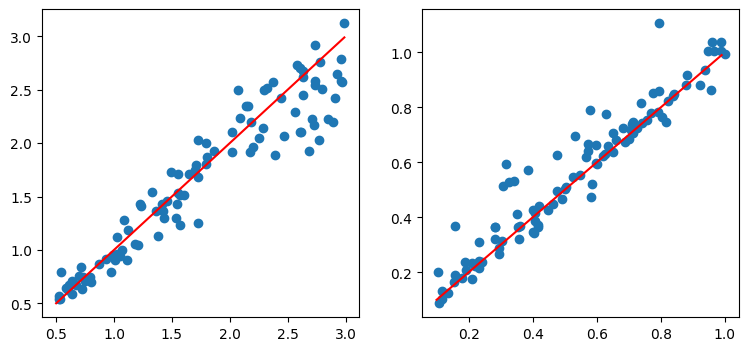

In [11]:
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))

print(r2_score(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold), 
      r2_score(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt))

print(pearsonr(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)[0], 
      pearsonr(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)
plt.plot(np.arange(0.5, 3, 0.01), np.arange(0.5, 3, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red');

437/437 [==============================] - 0s 298us/step
0.8674788527429931 0.8679461718058317
0.9332449913205847 0.9342930512925668


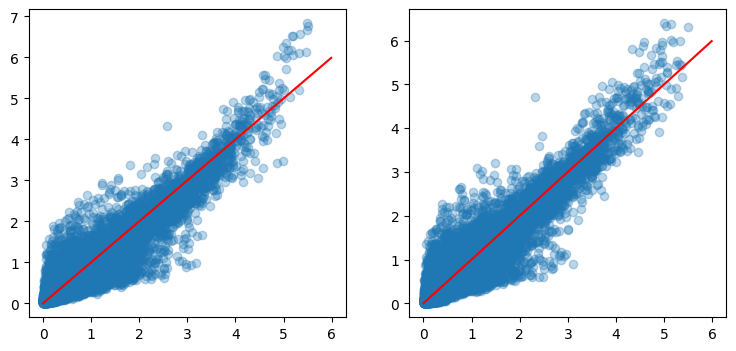

In [14]:
pred_v = model.predict(X_train)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in tr_df['sbj']])

print(r2_score(tr_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(tr_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(tr_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(tr_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

188/188 [==============================] - 0s 311us/step
0.8820696721591829 0.868074494860352
0.940951763048515 0.9344049791581647


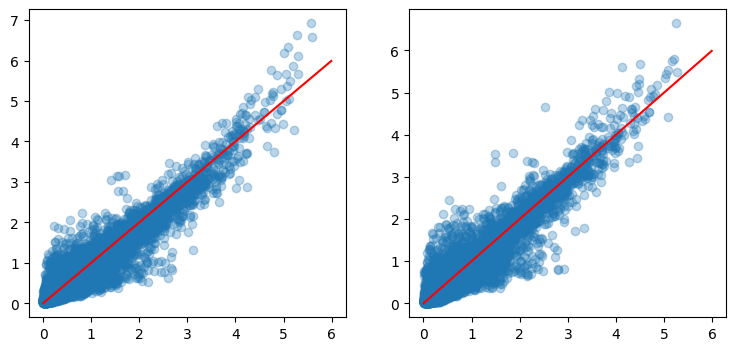

In [15]:
pred_v = model.predict(X_test)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

print(r2_score(ts_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(ts_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(ts_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(ts_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(ts_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(ts_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');